# Pablo's Playhouse for Data Analysis

In [31]:
# import libraries
import pandas as pd
import geopandas as gpd

# Define data path
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
dataPath_esp = '../data/merged_data/merged_birthPlace_spain_v_outside.csv'

# Load merged datasets
df_region = pd.read_csv(dataPath_region)
df_esp = pd.read_csv(dataPath_esp)









<Axes: >

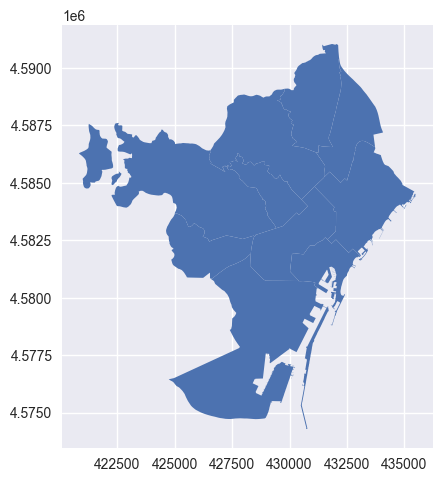

In [32]:
import geopandas as gpd

# Reading a GeoPackage file
input_file = "../data_original/esforc_lloguer/16-17_hab_dif_od.gpkg"
data = gpd.read_file(input_file)

# Show map preview
data.plot()



## Map of Barcelona Neighborhoods by District

(430018.6185, 4580195.801, 431677.344, 4581936.9845)


<Axes: >

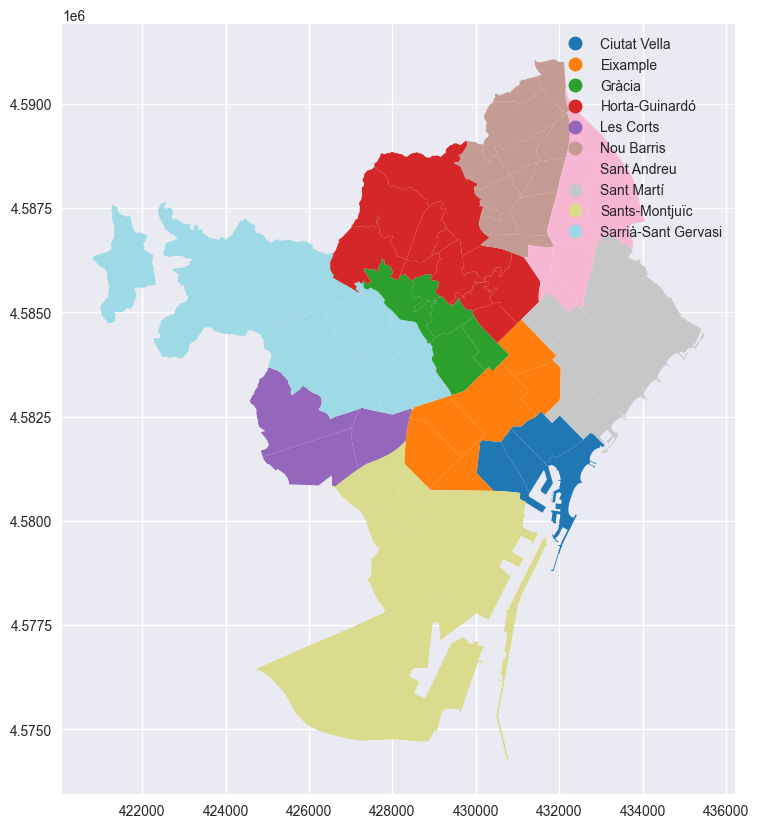

In [33]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

# read csv
path_barris = '../data_original/Codigo_valores/BarcelonaCiutat_Barris.csv'
df = pd.read_csv(path_barris)

# convert WKT strings to geometry objects
df["geometria_etrs89"] = df["geometria_etrs89"].apply(wkt.loads)   # or gpd.GeoSeries.from_wkt(df["geometry"])

# create GeoDataFrame and set the correct ETRS89 CRS
# Choose the right EPSG: EPSG:4258 for geographic ETRS89 (lat/lon),
# EPSG:25831 for ETRS89 / UTM zone 31N (meters) — choose one that matches your coordinates
gdf = gpd.GeoDataFrame(df, geometry="geometria_etrs89", crs="EPSG:25831")

# quick check of bounds to confirm units
print(gdf.geometry.iloc[0].bounds)

# Plot map with neighborhoods by district by color
gdf.plot(column="nom_districte", legend=True, figsize=(10, 10), cmap="tab20")






## Map of immigration in Barcelona by neighborhood

In [34]:
# import libraries
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
# read csv
path_barris = '../data_original/Codigo_valores/BarcelonaCiutat_Barris.csv'
df = pd.read_csv(path_barris)

# read csv from immigrant data
path_immigrant = '../data/merged_data/merged_birthPlace_spain_v_outside.csv'
df_immigrant = pd.read_csv(path_immigrant)
df_immigrant['Value'] = pd.to_numeric(df_immigrant['Value'], errors='coerce').fillna(0).astype(int)
df_immigrant['Birth_Place'] = df_immigrant['Birth_Place'].astype(str).str.strip()
# get data from 2025 only
df_immigrant_2025 = df_immigrant[df_immigrant['Year_Reference'] == 2025]

# total population by neighborhood
total = df_immigrant_2025.groupby(['District', 'Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'total_population'})

# population from Rest of European Union and Rest of World
eu = df_immigrant_2025[df_immigrant_2025['Birth_Place'] == 'Rest of European Union'].groupby(['District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'eu_population'})
world = df_immigrant_2025[df_immigrant_2025['Birth_Place'] == 'Rest of World'].groupby(['District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'world_population'})

# combine
summary = total.merge(eu, on=['District','Neighborhood'], how='left').merge(world, on=['District','Neighborhood'], how='left').fillna(0)
summary['outside_spain'] = summary['eu_population'] + summary['world_population']
# Calculate population from Spain
summary['spain_population'] = summary['total_population'] - summary['outside_spain']
# reorder columns
summary = summary[['District', 'Neighborhood', 'total_population', 'spain_population', 'outside_spain', 'eu_population', 'world_population']]
# Percentage of population from outside Spain
summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).round(2)


# save and inspect
summary.to_csv('../data/processed/neighborhood_population_summary_2025.csv', index=False)
print(summary.head())



       District                           Neighborhood  total_population  \
0  Ciutat Vella  Sant Pere, Santa Caterina i la Ribera             22755   
1  Ciutat Vella                         el Barri Gòtic             27863   
2  Ciutat Vella                               el Raval             49889   
3  Ciutat Vella                         la Barceloneta             14741   
4      Eixample                            Sant Antoni             39207   

   spain_population  outside_spain  eu_population  world_population  \
0              9273          13482           3384             10098   
1              6765          21098           2556             18542   
2             17183          32706           3848             28858   
3              6803           7938           2056              5882   
4             24197          15010           2585             12425   

   pct_outside_spain  
0              59.25  
1              75.72  
2              65.56  
3              53.85  
4

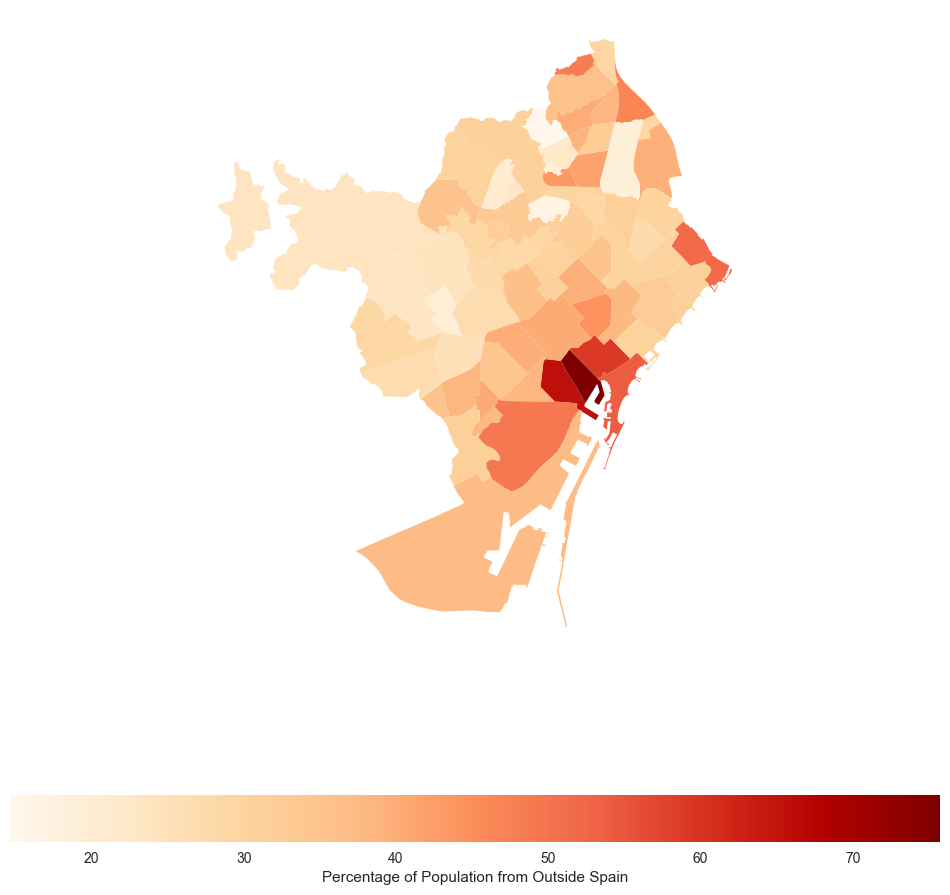

In [35]:
# Now we merge with geospatial data and plot
# convert WKT strings to geometry objects
df["geometria_etrs89"] = df["geometria_etrs89"].apply(wkt.loads)   # or gpd.GeoSeries.from_wkt(df["geometry"])
# create GeoDataFrame and set the correct ETRS89 CRS
# Choose the right EPSG: EPSG:4258 for geographic ETRS89 (lat/lon),
# EPSG:25831 for ETRS89 / UTM zone  31N (meters) — choose one that matches your coordinates
gdf = gpd.GeoDataFrame(df, geometry="geometria_etrs89", crs="EPSG:25831")
# merge with summary data
gdf_summary = gdf.merge(summary, left_on=['nom_districte', 'nom_barri'], right_on=['District', 'Neighborhood'], how='left')
# plot percentage of population from outside Spain
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
gdf_summary.plot(column='pct_outside_spain', ax=ax, legend=True, cmap='OrRd', 
                 legend_kwds={'label': "Percentage of Population from Outside Spain", 'orientation': "horizontal"})
#ax.set_title('Percentage of Population from Outside Spain by Neighborhood in Barcelona (2025)', fontsize=16)
ax.axis('off')
plt.show()

## Temporal series: GIF 

In [36]:
# Retrieve total population and immigration from outside Spain by neighborhood in Barcelona for every year
import pandas as pd
# read csv
path = '../data/merged_data/merged_birthPlace_spain_v_outside.csv'
df = pd.read_csv(path)
df['Value'] = pd.to_numeric(df['Value'], errors='coerce').fillna(0).astype(int)
df['Birth_Place'] = df['Birth_Place'].astype(str).str.strip()
years = df['Year_Reference'].unique()

# total population by neighborhood
total = df.groupby(['Year_Reference', 'District', 'Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'total_population'})

# population from Rest of European Union and Rest of World
eu = df[df['Birth_Place'] == 'Rest of European Union'].groupby(['Year_Reference', 'District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'eu_population'})
world = df[df['Birth_Place'] == 'Rest of World'].groupby(['Year_Reference', 'District','Neighborhood'], as_index=False)['Value'].sum().rename(columns={'Value':'world_population'})

# combine
summary = total.merge(eu, on=['Year_Reference', 'District','Neighborhood'], how='left').merge(world, on=['Year_Reference', 'District','Neighborhood'], how='left').fillna(0)
summary['outside_spain'] = summary['eu_population'] + summary['world_population']
# Calculate population from Spain
summary['spain_population'] = summary['total_population'] - summary['outside_spain']
# reorder columns with Year_Reference first and sort by year
summary = summary[['Year_Reference', 'District', 'Neighborhood', 'total_population', 'spain_population', 'outside_spain', 'eu_population', 'world_population']]
summary = summary.sort_values('Year_Reference')
# Percentage of population from outside Spain
summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).round(2)


# save and inspect
summary.to_csv('../data/processed/neighborhood_population_summary.csv', index=False)
print(summary.head())



    Year_Reference      District  \
0             1997  Ciutat Vella   
52            1997    Sant Martí   
51            1997    Sant Martí   
50            1997    Sant Martí   
49            1997    Sant Martí   

                                    Neighborhood  total_population  \
0          Sant Pere, Santa Caterina i la Ribera             19830   
52                         el Besòs i el Maresme             21495   
51                      Sant Martí de Provençals             27279   
50                       Provençals del Poblenou             16809   
49  Diagonal Mar i el Front Marítim del Poblenou              4127   

    spain_population  outside_spain  eu_population  world_population  \
0              17968           1862            295              1567   
52             21150            345             86               259   
51             26911            368             79               289   
50             16503            306             54               252   
49

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from shapely import wkt

# prepare geodataframe once
path_barris = '../data_original/Codigo_valores/BarcelonaCiutat_Barris.csv'
df_barris = pd.read_csv(path_barris)
df_barris["geometria_etrs89"] = df_barris["geometria_etrs89"].apply(wkt.loads)
gdf_barris = gpd.GeoDataFrame(df_barris, geometry="geometria_etrs89", crs="EPSG:25831")

# ensure Value numeric and Birth_Place normalized
df_immigrant = pd.read_csv('../data/merged_data/merged_birthPlace_spain_v_outside.csv')
df_immigrant['Value'] = pd.to_numeric(df_immigrant['Value'], errors='coerce').fillna(0).astype(int)
df_immigrant['Birth_Place'] = df_immigrant['Birth_Place'].astype(str).str.strip()

years = sorted(df_immigrant['Year_Reference'].unique())

# optional: compute global vmax for consistent color scale across years
def compute_pct_df(df_year):
    total = df_year.groupby(['District','Neighborhood'])['Value'].sum()
    eu = df_year[df_year['Birth_Place']=='Rest of European Union'].groupby(['District','Neighborhood'])['Value'].sum()
    world = df_year[df_year['Birth_Place']=='Rest of World'].groupby(['District','Neighborhood'])['Value'].sum()
    summary = (pd.concat([total, eu, world], axis=1)
                 .rename(columns={0:'total_population', 'Value':'ignore'})
                 .fillna(0))
    summary.columns = ['total_population','eu_population','world_population'] if summary.shape[1]==3 else summary.columns
    # safer explicit rebuild:
    summary = total.reset_index(name='total_population') \
             .merge(eu.reset_index(name='eu_population'), on=['District','Neighborhood'], how='left') \
             .merge(world.reset_index(name='world_population'), on=['District','Neighborhood'], how='left') \
             .fillna(0)
    summary['outside_spain'] = summary['eu_population'] + summary['world_population']
    summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).replace([np.inf, -np.inf], 0).fillna(0)
    return summary.reset_index(drop=True)

import numpy as np
# compute global vmax
all_pcts = []
for y in years:
    dfy = df_immigrant[df_immigrant['Year_Reference']==y]
    all_pcts.append(compute_pct_df(dfy)['pct_outside_spain'].max())
global_vmax = max(all_pcts) if all_pcts else 1

cmap = plt.cm.OrRd
norm = mpl.colors.Normalize(vmin=0, vmax=global_vmax)

for year in years:
    dfy = df_immigrant[df_immigrant['Year_Reference']==year]
    summary = compute_pct_df(dfy)
    gdf_summary = gdf_barris.merge(summary, left_on=['nom_districte','nom_barri'],
                                   right_on=['District','Neighborhood'], how='left')
    fig, ax = plt.subplots(1,1, figsize=(12,12))
    gdf_summary.plot(column='pct_outside_spain', ax=ax, cmap=cmap, norm=norm,
                     missing_kwds={'color':'lightgrey'}, linewidth=0.2, edgecolor='gray')
    # title with year
    #ax.set_title(f'Percentage of Population from Outside Spain by Neighborhood — {int(year)}', fontsize=16)
    # small label in corner with year
    ax.text(0.01, 0.99, f'Year: {int(year)}', transform=ax.transAxes,
            fontsize=12, va='top', ha='left', bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    # colorbar
    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []
    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.04, pad=0.02)
    cbar.set_label('Percentage of Population from Outside Spain (%)')
    ax.axis('off')
    plt.tight_layout()
    # ensure output folder exists and save figure
    import os
    out_dir = '../data/outputs'
    os.makedirs(out_dir, exist_ok=True)
    png_path = os.path.join(out_dir, f'pct_outside_spain_{int(year)}.png')
    fig.savefig(png_path, dpi=150, bbox_inches='tight')
    plt.close(fig)
    
# create gif from saved PNGs (1997-2025)
import imageio
import glob
pngs = sorted(glob.glob(os.path.join(out_dir, 'pct_outside_spain_*.png')))
# order by year in filename to be safe
pngs = sorted(pngs, key=lambda p: int(os.path.splitext(os.path.basename(p))[0].split('_')[-1]))
images = []
for p in pngs:
    images.append(imageio.v2.imread(p))
gif_path = os.path.join(out_dir, 'pct_outside_spain_1997_2025.gif')
# duration: seconds per frame (adjust to taste)
imageio.mimsave(gif_path, images, duration=0.6)
print("GIF saved to", gif_path)

GIF saved to ../data/outputs/pct_outside_spain_1997_2025.gif


### Temporal Series: Total immigration

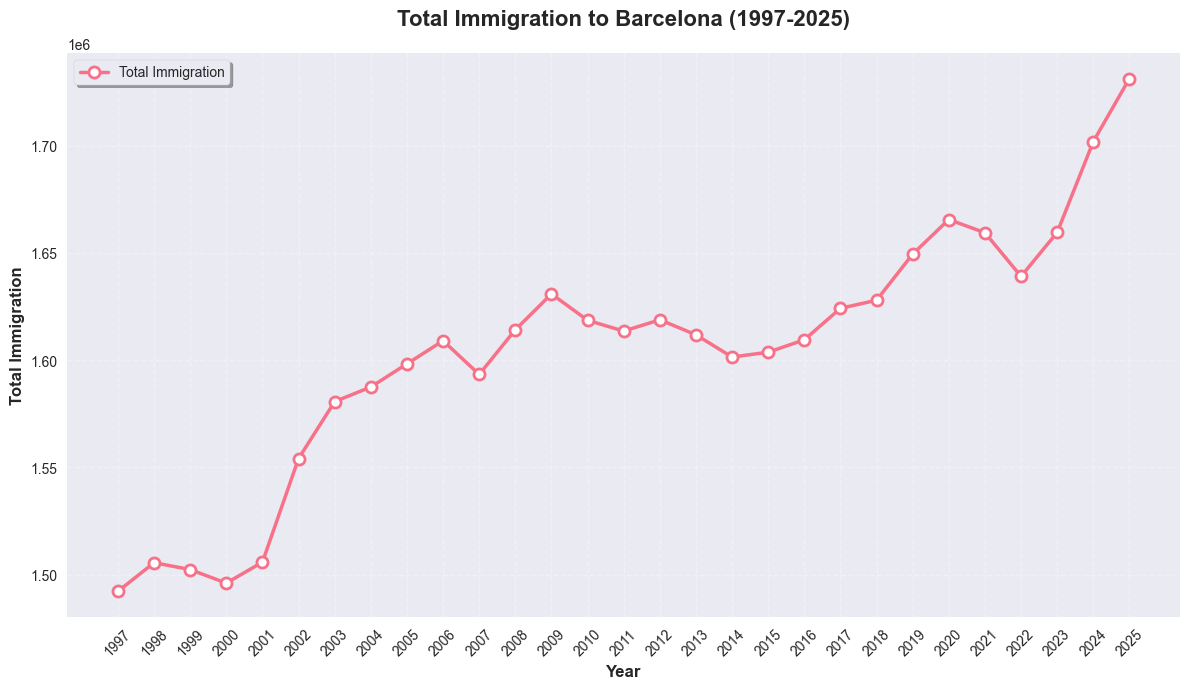

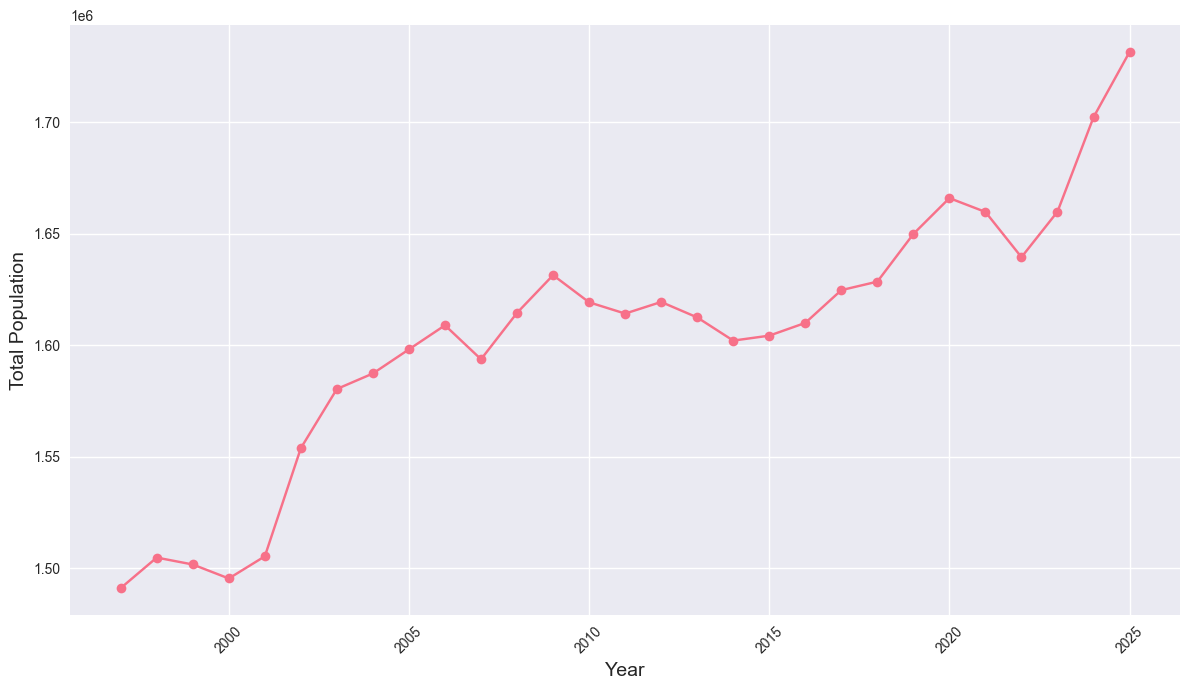

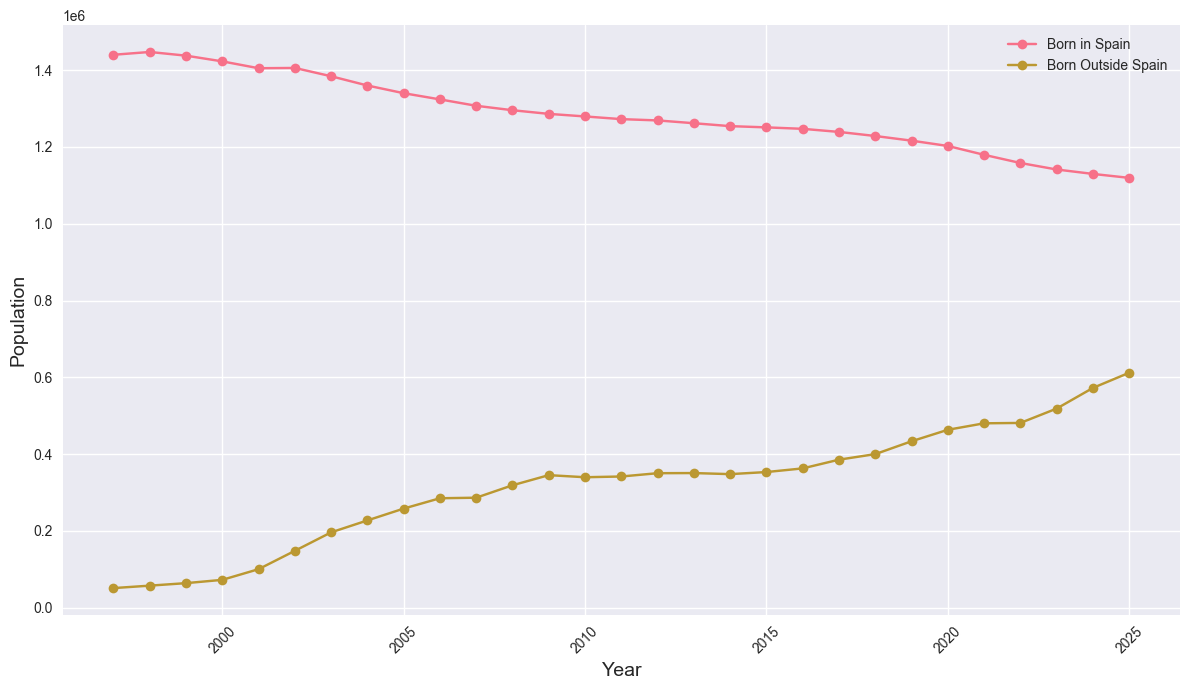

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
dataPath_region = '../data/merged_data/merged_birthPlaceRegion_sex.csv'
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_region = pd.read_csv(dataPath_region)
data_esp = pd.read_csv(dataPath_esp)

# Get total immigration by year in all Barcelona
total_immigration = data_region.groupby('Year_Reference', as_index=False)['Value'].sum().rename(columns={'Value':'total_immigration'})

# Plot temporal series
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7))

# Plot with enhanced styling
ax.plot(total_immigration['Year_Reference'], 
        total_immigration['total_immigration'], 
        marker='o', 
        linewidth=2.5, 
        markersize=8,
        markerfacecolor='white',
        markeredgewidth=2,
        label='Total Immigration')

# Enhanced styling
ax.set_title('Total Immigration to Barcelona (1997-2025)', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Year', fontsize=12, fontweight='bold')
ax.set_ylabel('Total Immigration', fontsize=12, fontweight='bold')

# Improve grid and ticks
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xticks(total_immigration['Year_Reference'])
ax.tick_params(axis='both', which='major', labelsize=10)

# Add some padding and rotate x-ticks if needed
plt.xticks(rotation=45)
plt.tight_layout()

# Add legend if you have multiple lines
ax.legend(frameon=True, fancybox=True, shadow=True)

# Remove spines for cleaner look
sns.despine(left=True, bottom=True)

plt.savefig('../data/outputs/total_immigration_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

# Figure with total population over time in Barcelona
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_esp = pd.read_csv(dataPath_esp)
# Aggregate
summary = data_esp.groupby('Year_Reference', as_index=False).agg({'total_population':'sum'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['total_population'], marker='o', linestyle='-')
#ax.set_title('<b>Total Population in Barcelona (1997-2025)</b>', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Total Population', fontsize=14)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/total_population_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

# Population born in Spain vs Outside Spain over time in Barcelona
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# Load data
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_esp = pd.read_csv(dataPath_esp)
# Aggregate
summary = data_esp.groupby('Year_Reference', as_index=False).agg({'spain_population':'sum',
                                                                  'outside_spain':'sum'})
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['spain_population'], marker='o', linestyle='-', label='Born in Spain')
ax.plot(summary['Year_Reference'], summary['outside_spain'], marker='o', linestyle='-', label='Born Outside Spain')
#ax.set_title('<b>Population Born in Spain vs Outside Spain in Barcelona (1997-2025)</b>', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Population', fontsize=14)
ax.grid(True)
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()
# Save figure
plt.savefig('../data/outputs/population_spain_vs_outside_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

Interactive plot with plotly (See how to fix it)

In [39]:
# Interactive plot with Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create interactive plot
fig = px.line(total_immigration, 
              x='Year_Reference', 
              y='total_immigration',
              title='<b>Total Immigration to Barcelona (1997-2025)</b>',
              markers=True,
              template='plotly_white')

# Enhance the styling
fig.update_traces(line=dict(width=3, color='#1f77b4'),
                  marker=dict(size=8, 
                             line=dict(width=2, color='white')),
                  hovertemplate='<b>Year: %{x}</b><br>Immigration: %{y:,}<extra></extra>')

# Update layout
fig.update_layout(
    xaxis=dict(
        title='<b>Year</b>',
        tickangle=45,
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='<b>Total Immigration</b>',
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    font=dict(
        family="Arial, sans-serif",
        size=12,
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    ),
    width=1000,
    height=600
)

# Save as interactive HTML and static image
fig.write_html('../data/outputs/total_immigration_barcelona_interactive.html')
#fig.write_image('../data/outputs/total_immigration_barcelona_plotly.png', scale=2)
fig.show()

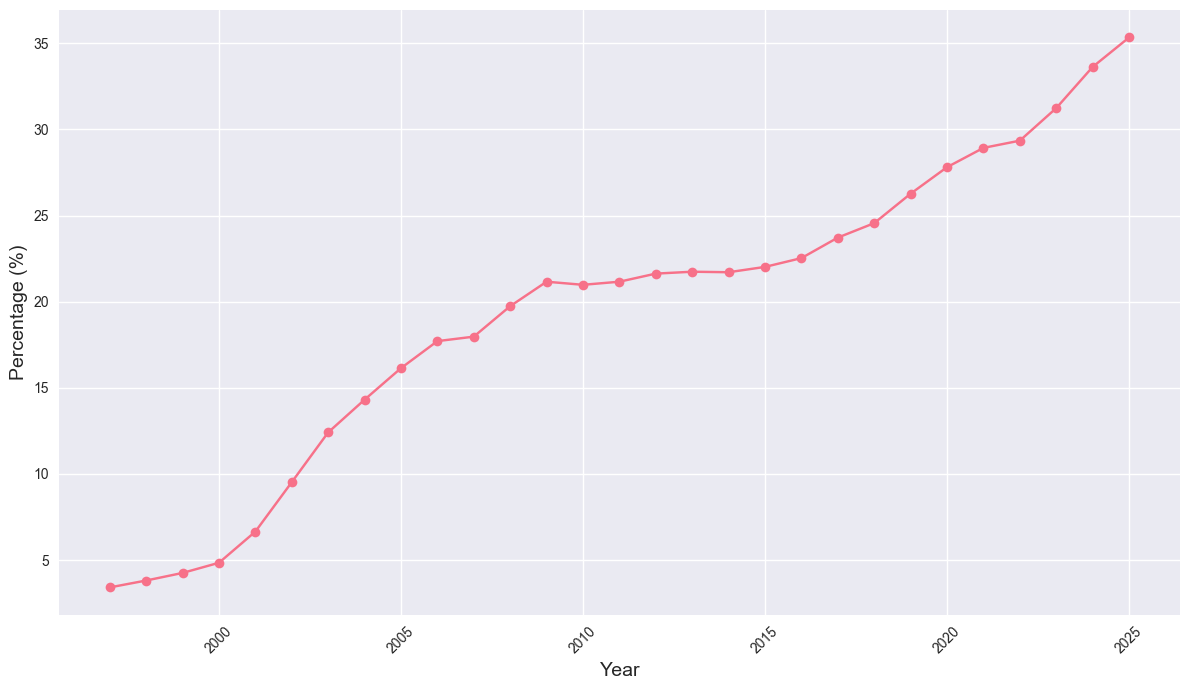

In [43]:
# Total percentage of immigration from outside Spain in Barcelona timeline plot 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
# Load data
dataPath_esp = '../data/processed/neighborhood_population_summary.csv'
data_esp = pd.read_csv(dataPath_esp)
# Aggregate
summary = data_esp.groupby('Year_Reference', as_index=False).agg({
    'total_population':'sum',
    'outside_spain':'sum'
})
summary['pct_outside_spain'] = (summary['outside_spain'] / summary['total_population'] * 100).round(2)
# Create the plot
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig, ax = plt.subplots(figsize=(12, 7))
# Plot with enhanced styling
ax.plot(summary['Year_Reference'], summary['pct_outside_spain'], marker='o', linestyle='-')
#ax.set_title('<b>Percentage of Immigration from Outside Spain in Barcelona</b>', fontsize=16)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percentage (%)', fontsize=14)
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Save figure
plt.savefig('../data/outputs/pct_immigration_outside_spain_barcelona.png', 
            dpi=300, bbox_inches='tight', transparent=False)
plt.show()

